In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from pathlib import Path
import sys
import pickle
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [16]:
repo_dir = Path('../..')

In [17]:
if str(repo_dir) not in sys.path:
    sys.path.append(str(repo_dir))
    
from analysis.curve_fitting.src.fitting_functions import LOSS_FUNCTIONS
from analysis.curve_fitting.src.utils import apply_filters, load_yaml, convert_loss_parameters, convert_loss_parameters_batch

from visualization.src.utils import COLOR_PALETTES, set_ticks, COLORS, save_figs
from visualization.src.visualize import plot_reg, plot_reg_bivariate, plot_confidence_intervals



In [18]:
args = {
    'results_csv': repo_dir / 'results' / 'benchmark_scores_local.csv',
}

In [19]:
results_csv = args['results_csv']

df_results = pd.read_csv(results_csv)
df_results['total_flops'] = df_results['flops'] * df_results['n_samples_seen']

## Load Experiment Configuration

In [20]:
analysis_dir = repo_dir / 'analysis'
config_dir = analysis_dir / 'curve_fitting/configs/parameter'
results_dir = analysis_dir / 'curve_fitting/fitting_results'

In [21]:
experiment_name = "parameter_scaling"
config = load_yaml(config_dir / f'{experiment_name}.yaml')


In [22]:
L_fit = config['fitting_parameters']['loss_function']
L_viz = config['visualization']['loss_function']
x_scaler = float(config['fitting_parameters']['X_scaler'])



## Apply Data Filters

In [23]:
df = apply_filters(df_results, config.get('data_filters', {}))


## Load Fitting Results

In [24]:
with open(results_dir / f'{experiment_name}' / 'results.pkl', 'rb') as f:
    results = pickle.load(f)


optimized_params = convert_loss_parameters(results['optimized_parameters'], L_fit, L_viz)

# Convert bootstrapped parameters
opt_params_boot = results['optimized_parameters_bootstrapped']
opt_params_boot = convert_loss_parameters_batch(
    params=opt_params_boot,
    src_loss=L_fit,
    dst_loss=L_viz
)

## Visualize

#### Plotting settings

In [25]:
x_extend = 1.1
X_str = r'$$\tilde{N}$$'
linewidth = 3.0
alpha_scatter = 1.0
alpha_ci = 0.2
alpha_fit = 1.0
fig_multiplier = 0.7
figsize = (10, 8)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])

color_palaette = COLOR_PALETTES['models']
color = "#023e8a"

#### Plot

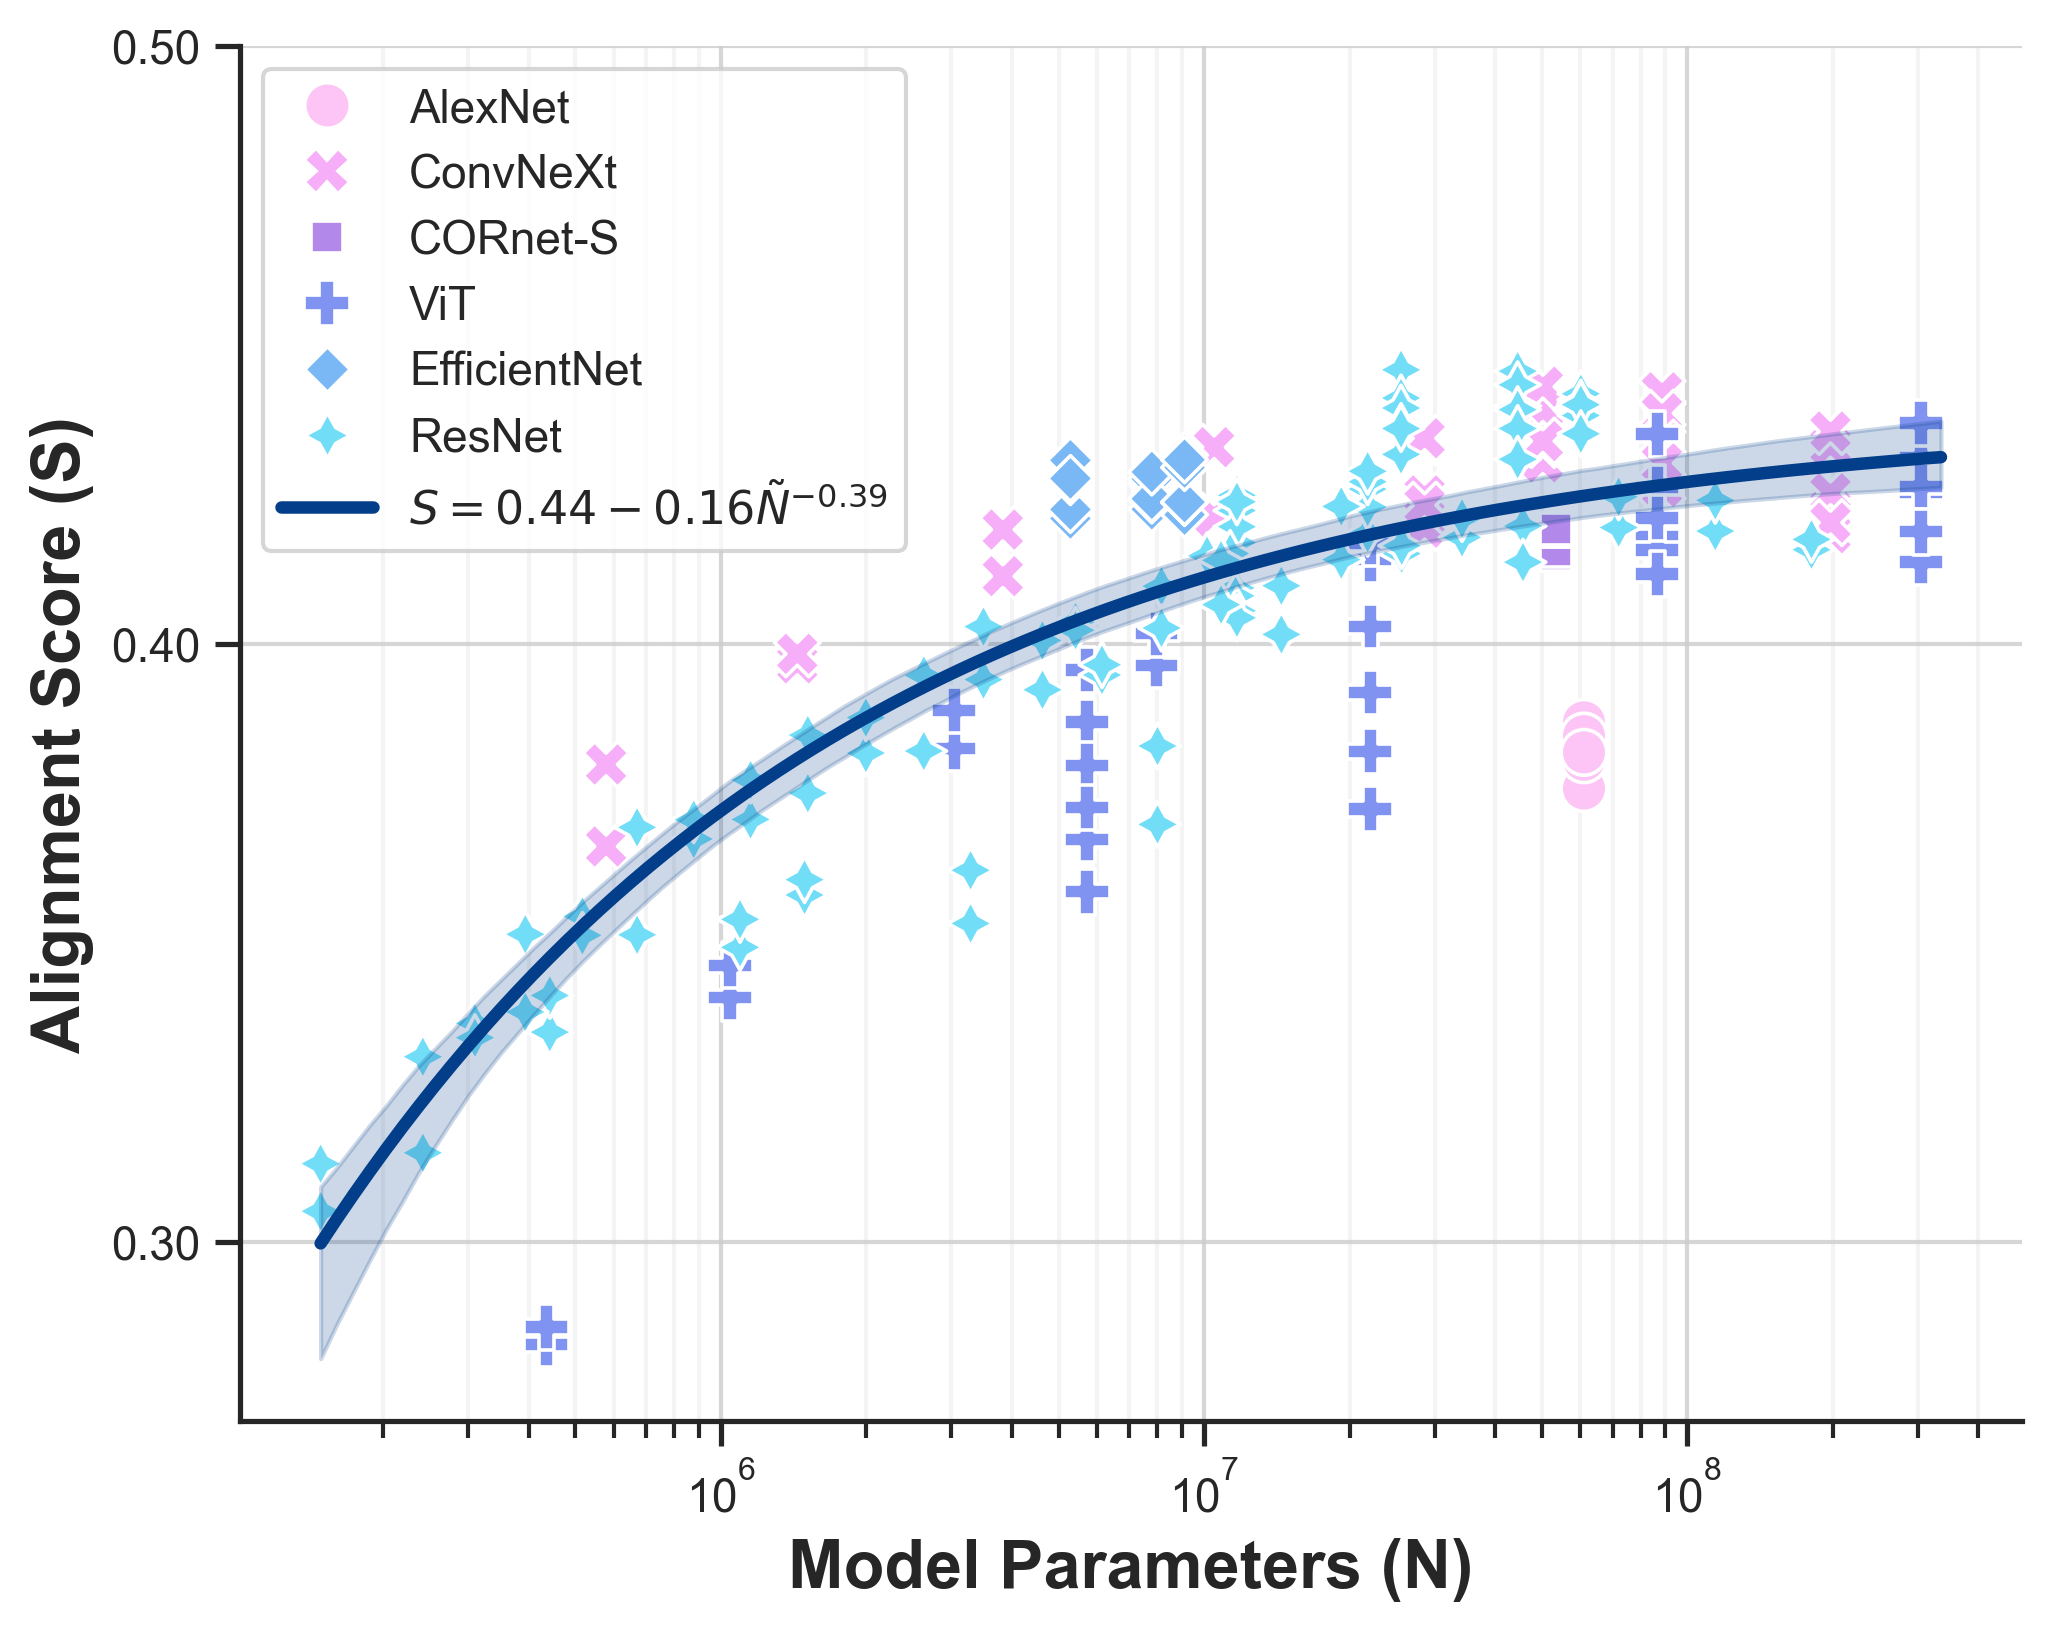

In [26]:
sns.set_theme(style='whitegrid')
sns.set_theme(style='ticks')


fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=300)

ax = axes

### Neuro
df_plot = df
L = LOSS_FUNCTIONS[L_viz]
x_scaler = x_scaler
X = df_plot.n_params.values / x_scaler



df_plot.rename(columns={'arch_family': 'Architecture'}, inplace=True)
sns.scatterplot(data=df_plot, x='n_params', y='score', ax=ax, hue='Architecture', style='Architecture', s=120, palette=color_palaette, alpha=alpha_scatter)
plot_reg(X, optimized_params, L, ax, color=color, x_extend=x_extend, linestyle='-', X_str=X_str, x_scaler=x_scaler, show_x_scaler=False, linewidth=linewidth, legend=True, alpha=alpha_fit)
plot_confidence_intervals(X, opt_params_boot, L, ax, color=color, x_extend=x_extend, x_scaler=x_scaler, alpha=alpha_ci, percentile=95.0, invert_y=True)

### Formatting
ax.set_xscale('log')
ax.set_xlabel('Model Parameters (N)', fontsize=16, fontweight='bold')
ax.set_ylabel('Alignment Score (S)', fontsize=16, fontweight='bold')
# ax.set_title(arch_family, fontsize=20, fontweight='bold')
ax = set_ticks(ax, xticks_mode='log', yticks_mode=None, yticks=[0.2, 0.3, 0.4, 0.5])
ax.set_ylim(0.27, 0.5)

ax.spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()


figures_dir = '../figures'
fig_name = 'fig2_params'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)
